In [1]:
!pip install pymde pandas torch seaborn holoviews

In [2]:
!pip install tensorflow

In [3]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymde

In [14]:
dir_path = "data/cmnist/1pct/align/"
c_dir_path = "data/cmnist/1pct/conflict/"

In [5]:
for dirpath, dirname, images in os.walk(dir_path):
    print(f"There are {len(dirname)} directories with {len(images)} images in {dirpath}")
    

There are 10 directories with 1 images in data/cmnist/1pct/align/
There are 0 directories with 5431 images in data/cmnist/1pct/align/9
There are 0 directories with 5366 images in data/cmnist/1pct/align/0
There are 0 directories with 5709 images in data/cmnist/1pct/align/7
There are 0 directories with 5417 images in data/cmnist/1pct/align/6
There are 0 directories with 6142 images in data/cmnist/1pct/align/1
There are 0 directories with 5279 images in data/cmnist/1pct/align/8
There are 0 directories with 5268 images in data/cmnist/1pct/align/4
There are 0 directories with 5565 images in data/cmnist/1pct/align/3
There are 0 directories with 5404 images in data/cmnist/1pct/align/2
There are 0 directories with 4928 images in data/cmnist/1pct/align/5


Found 54509 files belonging to 10 classes.


2022-09-05 12:21:27.314242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


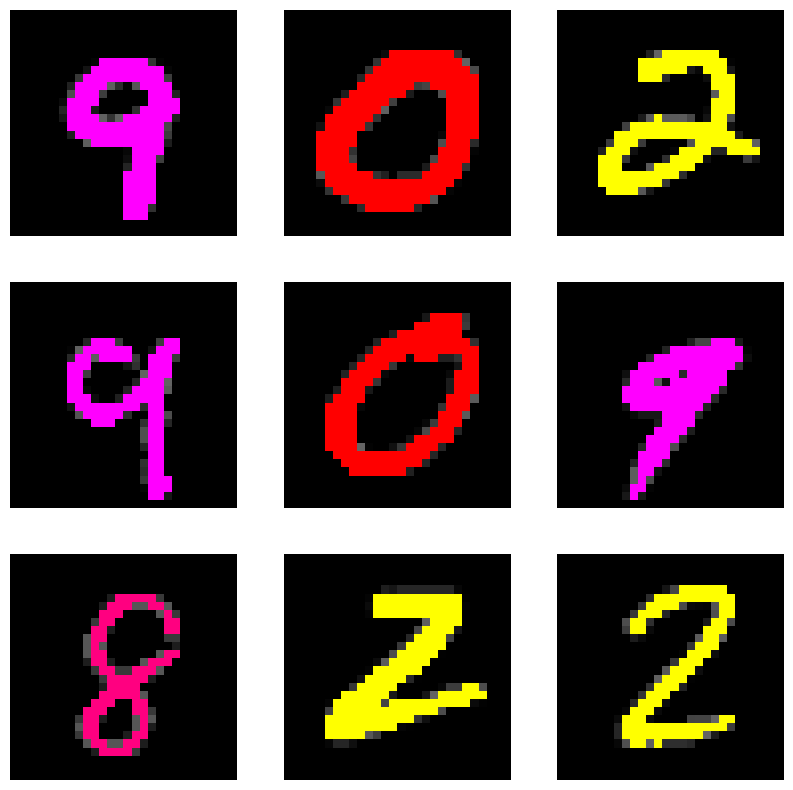

In [6]:
IMAGE_SIZE = (28, 28)

train_dir = tf.keras.preprocessing.image_dataset_from_directory(dir_path,image_size=IMAGE_SIZE)#,label_mode='binary')

plt.figure(figsize=(10, 10))
for images, labels in train_dir.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        im = images[i].numpy().astype("uint8")
        plt.imshow(im)
        plt.axis("off")

In [15]:
CLASS_LABELS = range(0,10)



def process_path(nb_class):
    
    """
    As the function map from Dataset object is waiting a function, 
    we created process path to set the number of class desired. Then you can set nb_class to 2 
    if you want to analyse only PNEUMONIA/NORMAL set.
    
    parameters:
    -----------
        nb_class: int
        
    returns:
    --------
        f: Function used in map.
    """
    
    def f(file_path):
        
        """
        This function takes the files path as arguement and apply some preprocessing functions.
        It also create labels according to name's file. Then NORMAL images become 0, BACTERA is 1 and VIRUS 2.

        parameters:
        -----------
            file_path: str

        returns:
        --------
            image, label: tensor, tensor.
        """
        
        label = tf.strings.split(file_path, os.path.sep)[-2]
            
        image = tf.io.read_file(file_path)    
        image = tf.image.decode_jpeg(image, channels=1)
        image = tf.image.convert_image_dtype(image, tf.float32)
         
        # We resize images to (127, 127) because the smallest image in the dataset is 127.
        #image = tf.image.resize(image, [28, 28], method='area')
        
        
        
        
        # Uncomment to crop 
        #image = tf.image.central_crop(image, .6)
        
        
        return image, label, file_path
    
    return f

def reader_image(path_file, batch_size, nb_class):
    
    """
    This function is containing the two previous one then that' why we arge getting the same parameters.

    parameters:
    -----------
        file_path: str
        batch_size: int
        nb_class: int

    returns:
    --------
        dataset object.
    """

    list_ds = tf.data.Dataset.list_files(path_file)
    labeled_ds = list_ds.map(process_path(nb_class))
    
    return labeled_ds.batch(batch_size).prefetch(1), list_ds.batch(batch_size).prefetch(1)

train_ds, train_l = reader_image(dir_path+'*/*.png', 16, 2)

c_train_ds, c_train_l = reader_image(c_dir_path+'*/*.png', 16, 2)

# uncomment to check test images 
#train_ds, train_l = reader_image('chest_xray/test/*/*.jpeg', 16, 2)



Outoupt : 
 image shape: (28, 28) and maximum/minimum values: (1, 0)


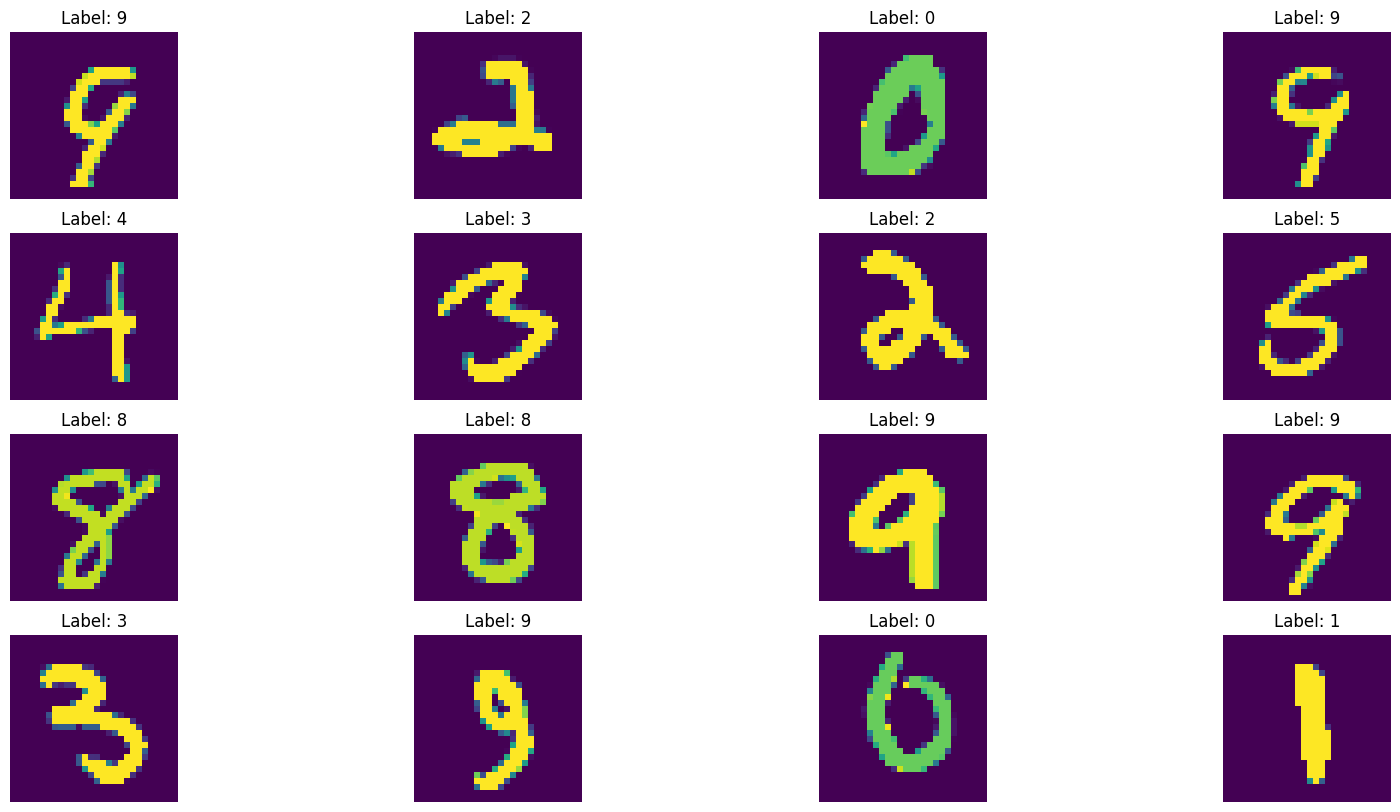

In [8]:
for image, label, fn in train_ds.take(1):
    df = pd.DataFrame(image[0, :, :, 0].numpy())
    
print(f'Outoupt : \n image shape: {df.shape} and maximum/minimum values: {round(df.max().max()), round(df.min().min())}')

plt.figure(figsize=(20, 10))

for images, labels, fp in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        im = images[i, :, :,  0]#.numpy()
        plt.imshow(im)
        plt.title('Label: '+ str(int(labels[i].numpy())))
        plt.axis("off")

In [9]:
def get_numpy(ds):
    
    """
    Function used to translate Dataset object into numpy array.
    
    parameters:
    -----------
        ds: Dataset
        
    returns:
    --------
        X: numpy array.
        y: numpy array.
    """
    
    X, y , fps = [], [], []
    for images, labels, fp in ds: 
        im = images
        X.append(im)
        y.append(labels)
        fps.append(fp)
        
    X = np.concatenate(X, axis=0)
    X = X.reshape(X.shape[0], -1)
    y = np.concatenate(y, axis=0)
    fps = np.concatenate(fps, axis=0)
    
    return X, y, fps

In [16]:
X, y, fps = get_numpy(train_ds)
c_X, c_y, c_fps = get_numpy(c_train_ds)

<AxesSubplot:>

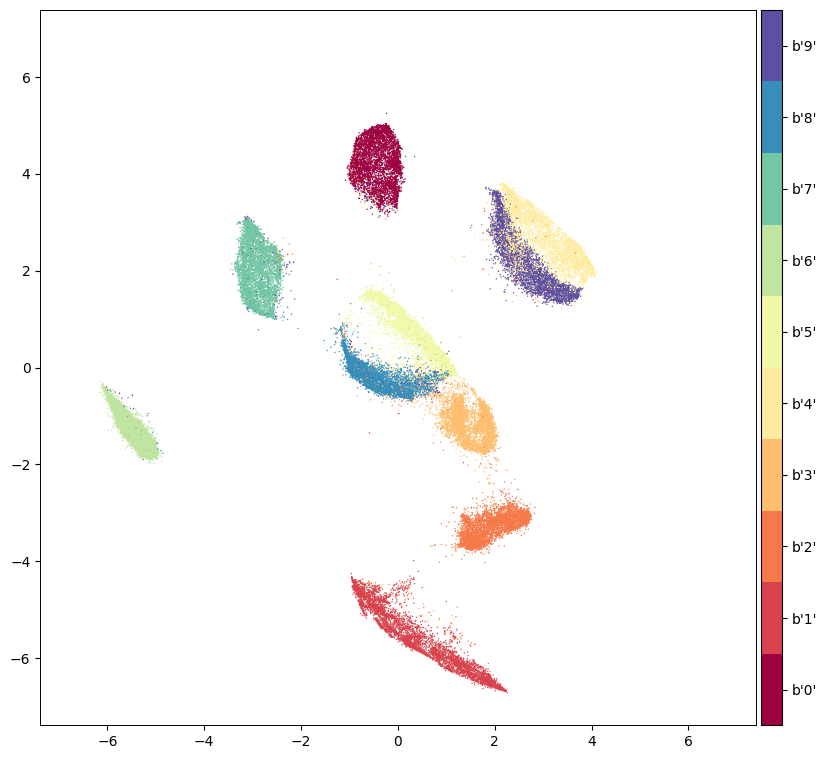

In [11]:
mde = pymde.preserve_neighbors(np.array(X), embedding_dim=2)
pymde.plot(mde.embed(), color_by=y)

<AxesSubplot:>

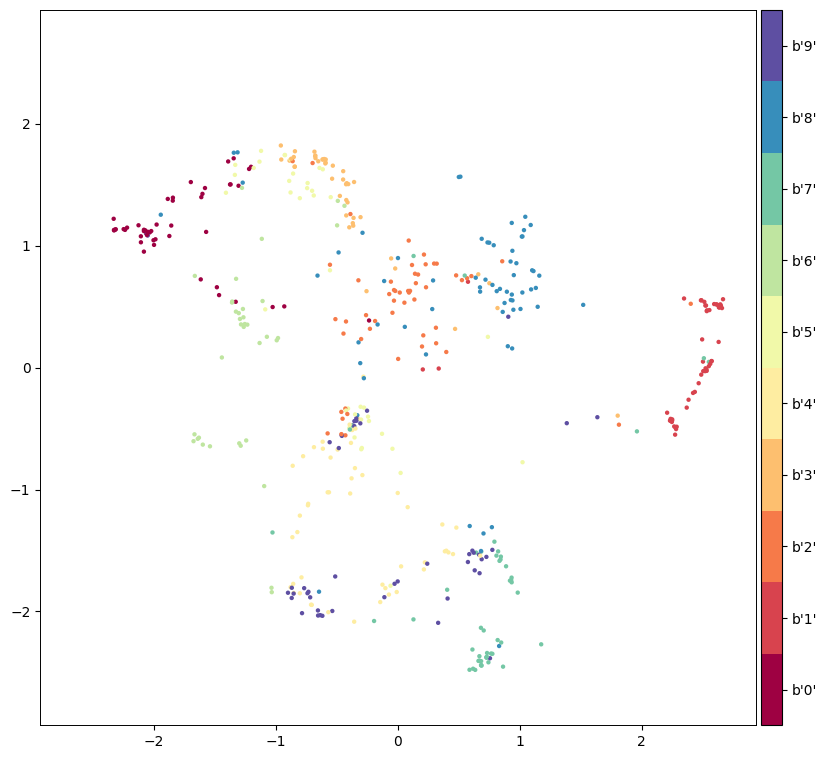

In [18]:
mde = pymde.preserve_neighbors(np.array(c_X), embedding_dim=2)
pymde.plot(mde.embed(), color_by=c_y, marker_size=10)